**Кулешов Иван AML-14**

# Домашнее задание «Тематическое моделирование»

In [ ]:
!pip install pymorphy2==0.9.1

In [ ]:
import numpy as np
import pandas as pd

import json
import bz2

import re

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')

from pymorphy2 import MorphAnalyzer

from string import punctuation
from collections import Counter

from tqdm import tqdm
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline


from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Используется инструмент google colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Считываем датасет

In [ ]:
PATH = "/content/drive/MyDrive/banki/banki_responses.json.bz2"

In [ ]:
responses = []
with bz2.BZ2File(PATH, 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [03:08, 1065.98it/s]


Посмотрим на пример отзыва:

In [ ]:
responses[0]

{'city': 'г. Москва',
 'rating_not_checked': False,
 'title': 'Жалоба',
 'num_comments': 0,
 'bank_license': 'лицензия № 2562',
 'author': 'uhnov1',
 'bank_name': 'Бинбанк',
 'datetime': '2015-06-08 12:50:54',
 'text': 'Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удо

In [ ]:
df = pd.DataFrame(responses)
responses = None
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


# Часть 1. Анализ Текстов

### 1.1. Количество отзывов в разных городах и на разные банки

Количество отзывов по городам:

In [ ]:
df['city'].value_counts()

г. Москва                               55354
г. Санкт-Петербург                      14342
г. Екатеринбург                          2337
г. Новосибирск                           2300
г. Нижний Новгород                       1976
                                        ...  
г. г.Калуга                                 1
г. ВЕЛИКИЕ ЛУКИ                             1
г. всеволожск                               1
г. сейчас                                   1
г. Краснодарский край, ст.Павловская        1
Name: city, Length: 5823, dtype: int64

Количество отзывов по банкам:

In [ ]:
df['bank_name'].value_counts()

Сбербанк России     26327
Альфа-Банк          10224
ВТБ 24               8185
Русский Стандарт     7943
Хоум Кредит Банк     7549
                    ...  
Сиббизнесбанк           1
Донбанк                 1
Потенциал               1
Ури Банк                1
БайкалИнвестБанк        1
Name: bank_name, Length: 670, dtype: int64

## 1.2. Гистограмы длин отзывов в символах и в словах:

Отзывы в символах:

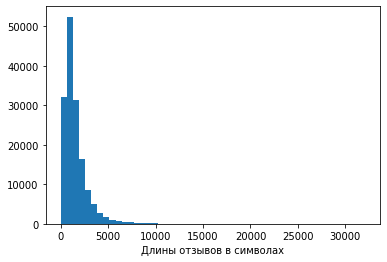

In [ ]:
len_symbols = df.text.apply(len)
len_symbols.plot(kind='hist',bins=50)
plt.xlabel('Длины отзывов в символах')
plt.ylabel('')
plt.show()

Установим границу отображения в 10000 символов:

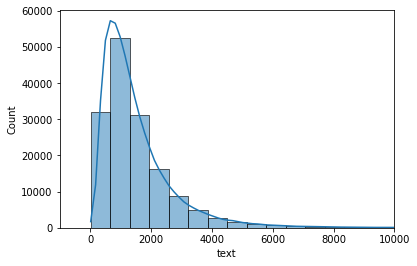

In [ ]:
sns_plot = sns.histplot(len_symbols, bins=50, kde=True)
sns_plot.set(xlim=(-1000,10000))
fig = sns_plot.get_figure();

Отзывы в словах:

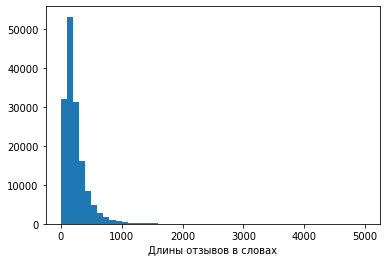

In [ ]:
len_tokens = df.text.str.split().apply(len)
len_tokens.plot(kind='hist',bins=50)
plt.xlabel('Длины отзывов в словах')
plt.ylabel('')
plt.show()

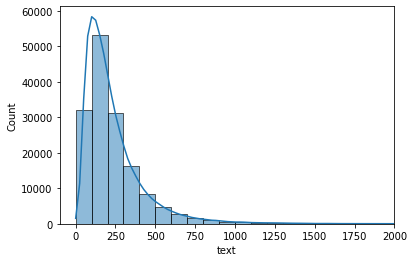

In [ ]:
sns_plot = sns.histplot(len_tokens, bins=50, kde=True)
sns_plot.set(xlim=(-100,2000))
fig = sns_plot.get_figure();

## 1.3. Найдите 10 самых частых: слов, слов без стоп-слов, лемм, существительных

Проведем с датасетом некоторые преобразования

In [ ]:
df['text_orig'] = df['text'] # сохраняем оригинальный текст обращения
df['text'] = df['text'].str.lower() # переводим в нижний регистр

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

from string import punctuation
from collections import Counter

punctuation

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# 10 самых частых слов
tokens_without_punctuation = [token for comment in df.text for token in word_tokenize(
    comment) if token not in punctuation]
    
freq_dict = Counter(tokens_without_punctuation)
freq_dict.most_common(10)

[('в', 1322516),
 ('и', 1054485),
 ('не', 851742),
 ('на', 704396),
 ('что', 621783),
 ('я', 573896),
 ('с', 454545),
 ('по', 365188),
 ('мне', 320695),
 ('банка', 263958)]

Самые часто встречаемые токены можно использовать как стоп-слова:

In [ ]:
mystopwords = stopwords.words('russian') + ['в', 'и', 'не', 'на', 'что', 'я', 'с', 'по', 'мне', 'банк', 'банка'] + ['который', 'прошлый', 'сей', 'свой', 'наш', 'мочь', 'г']
mystopwords += ["``", "''", "...", "."]

In [ ]:
# 10 самых частых слов без стоп-слов
tokens_without_stopwords = [token for token in tokens_without_punctuation if token not in mystopwords]
Counter(tokens_without_stopwords).most_common(10)

[('это', 183054),
 ('деньги', 130061),
 ('карту', 104947),
 ('карты', 100877),
 ('кредит', 80281),
 ('день', 75996),
 ('заявление', 69524),
 ('отделение', 66468),
 ('очень', 66174),
 ('время', 65554)]

Проведем дополнительную очистку: оставим только русские буквы, чтобы избавиться от разной числовой информации, транслита, возможных ников/названий почты и т.п.

In [ ]:
ru_words = re.compile("[А-Яа-я]+")

def ru_words_only(text):
    return " ".join(ru_words.findall(text))

df.text = df.text.apply(ru_words_only)

Проведем лемматизацию, для этого создадим новый столбец lemma, содержащий лемматизированный text. В список стоп-слов внесём небольшое изменение:

In [ ]:
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

Функция для лемматизации столбца датафрейма

In [ ]:
# частицу "не" не станем убирать
mystopwords = list(set(mystopwords) - set(['не']))

In [ ]:
def lemmatize(text, morf=pymorphy2_analyzer):
  # Разделим текст на токены, удалив пунктуацию
  tokens_without_punctuation = [token for token in word_tokenize(text) if token not in punctuation]
  # Каждое получившееся слово лемматизируем и объединяем через пробел в одну строку, удалив стоп-слова
  return " ".join(
      [morf.parse(word)[0].normal_form for word in tokens_without_punctuation
       if word not in mystopwords]
      )

In [ ]:
df['lemma'] = df['text'].apply(lemmatize)

Сохранение-считывание результата

In [ ]:
df.to_csv("/content/drive/MyDrive/banki/lemma.csv")

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/banki/lemma.csv")

In [ ]:
# 10 самых частых лемм
lemmatized_tokens = [word for lemma in df.lemma for word in lemma.split()]
Counter(lemmatized_tokens).most_common(10)

[('карта', 331816),
 ('это', 199740),
 ('деньга', 178337),
 ('день', 172634),
 ('мой', 167035),
 ('банк', 164013),
 ('кредит', 154863),
 ('отделение', 143616),
 ('счёт', 140509),
 ('сотрудник', 133662)]

In [ ]:
Nouns = [word for word in lemmatized_tokens if pymorphy2_analyzer.parse(word)[0].tag.POS == "NOUN"]
Counter(Nouns).most_common(10)

In [ ]:
Counter(Nouns).most_common(10)

[('карта', 331816),
 ('деньга', 178337),
 ('день', 172634),
 ('банк', 164013),
 ('кредит', 154863),
 ('отделение', 143616),
 ('счёт', 140509),
 ('сотрудник', 133662),
 ('клиент', 132908),
 ('сумма', 110914)]

## 1.4. Кривые Ципфа и Хипса

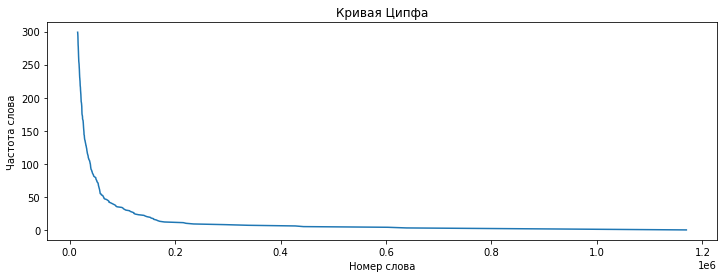

In [ ]:
freqs = list(freq_dict.values())
freqs = sorted(freqs, reverse=True)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(freqs[:300], range(300))
plt.xlabel('Номер слова')
plt.ylabel('Частота слова')
plt.title('Кривая Ципфа')
plt.show()


In [ ]:
cnt = Counter()
n_words = []
n_tokens = []
tokens = []
for index, row in tqdm(df.iterrows(), total=len(df)):
    tokens = word_tokenize(row.text)
    cnt.update([token for token in tokens if token not in punctuation])
    n_words.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))

100%|██████████| 153499/153499 [1:18:27<00:00, 32.61it/s]


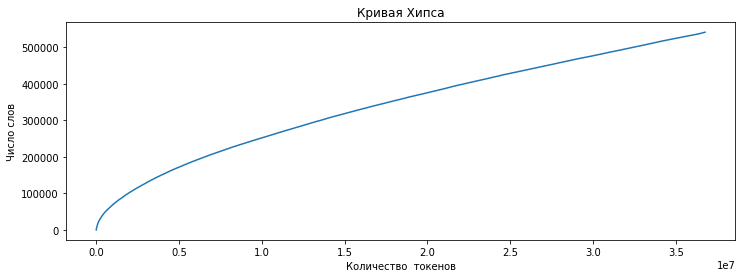

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(n_tokens, n_words)
plt.xlabel('Количество  токенов')
plt.ylabel('Число слов')
plt.title('Кривая Хипса')
plt.show()


Как видно, закон Ципфа показывает обратную зависимость между частотой втречаемости слова и его рангом (порядковый номер в списке по убыванию частотности). Закон Хипса на данном корпусе текстов иллюстрирует, что с ростом текстов новые слова все реже пополняют лексикон.

## 1.5. Ответы на вопросы

- какое слово встречается чаще, "сотрудник" или "клиент"?
- сколько раз встречается слова "мошенничество" и "доверие"?

In [ ]:
from nltk import FreqDist
Freq_Dist = FreqDist(tokens_without_stopwords)

In [ ]:
print('Слово "сотрудник" встречается -"', Freq_Dist['сотрудник'], 'раз')
print('Слово "клиент" встречается -"', Freq_Dist['клиент'], 'раз')

Слово "сотрудник" встречается -" 24513 раз
Слово "клиент" встречается -" 15595 раз


In [ ]:
print('Слово "мошенничество" встречается -"', Freq_Dist['мошенничество'], 'раз')
print('Слово "доверие" встречается -"', Freq_Dist['доверие'], 'раз')

Слово "мошенничество" встречается -" 972 раз
Слово "доверие" встречается -" 1024 раз


## 1.6. Ключевые слова и биграммы для положительных (оценка 5) и отрицательных (оценка 1) отзывов

В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

Отберем позитивные и негативные отзывы и векторизуем их:

In [ ]:
positive = df.loc[df.rating_grade==5]
negative = df.loc[df.rating_grade==1]

Обучим векторизатор на всем корпусе текстов, с учетом стоп-слов, и отсечем слова с низкой встречаемостью, частотой ниже 3:

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words=mystopwords, min_df=3)
tfidf_matrix = tfidf.fit(df.text)

### Униграммы положительных и негативных

In [ ]:
print('Ключевые слова для положительных отзывов')
vec_pos = tfidf.transform(positive.text)
sorted(list(zip(tfidf_matrix.vocabulary_.keys(), vec_pos.sum(0).getA1())), key = lambda i: i[1], reverse =True)[:10]

Ключевые слова для положительных отзывов


[('смертному', 839.9036472400663),
 ('комн', 531.2759056057245),
 ('безнале', 333.5482701828905),
 ('стрима', 321.59909554596874),
 ('гашением', 319.8245407495871),
 ('инструкциями', 258.2769958911144),
 ('показателя', 256.69921322519514),
 ('находку', 247.0754626180709),
 ('исчезла', 245.77081608501788),
 ('ных', 235.80729236622324)]

In [ ]:
print('Ключевые слова для отрицательных отзывов')
vec_neg = tfidf.transform(negative.text)
sorted(list(zip(tfidf_matrix.vocabulary_.keys(), vec_neg.sum(0).getA1())), key = lambda i: i[1], reverse =True)[:10]

Ключевые слова для отрицательных отзывов


[('смертному', 4123.011401617791),
 ('ных', 1340.4447299931508),
 ('стрима', 1244.091234700497),
 ('находку', 1050.930976212182),
 ('прибавили', 951.2853777690071),
 ('внимать', 937.6439059515952),
 ('потребления', 851.7847351987076),
 ('показателя', 850.552380933761),
 ('поиграть', 753.3526484714193),
 ('накупила', 738.0381709868192)]

### Биграммы положительных и негативных

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(2, 2), stop_words=mystopwords, min_df=3)
tfidf_matrix = tfidf.fit(df.text)

In [ ]:
print('Биграммы для положительных отзывов')
vec_pos = tfidf.transform(positive.text)
sorted(list(zip(tfidf_matrix.vocabulary_.keys(), vec_pos.sum(0).getA1())), key = lambda i: i[1], reverse =True)[:10]

Биграммы для положительных отзывов


[('рс страхование', 62.85808880312314),
 ('евро заявление', 58.975316411072704),
 ('вс норме', 58.837682083527405),
 ('долго нахожусь', 57.75982051076756),
 ('ошибочно перечислены', 55.59691785084796),
 ('приедет подпишет', 55.3770742203281),
 ('не скрывается', 52.918179105331525),
 ('магазине пришла', 51.354915928094364),
 ('утвержд нных', 49.09706196699977),
 ('финансового партнера', 47.41065133504188)]

In [ ]:
print('Биграммы для отрицательных отзывов')
vec_neg = tfidf.transform(negative.text)
sorted(list(zip(tfidf_matrix.vocabulary_.keys(), vec_neg.sum(0).getA1())), key = lambda i: i[1], reverse =True)[:10]

Биграммы для отрицательных отзывов


[('операционистов человек', 267.9511960687683),
 ('утра зашел', 221.93715026116217),
 ('утвержд нных', 203.68540399598214),
 ('узнать насчет', 198.41623166915664),
 ('звонка старшего', 195.45950098160702),
 ('безопасности якобы', 182.15970117288487),
 ('также адресу', 175.94371194211078),
 ('однако отделении', 167.02650346523404),
 ('евро заявление', 163.96093662854025),
 ('клиентами показывают', 159.59636621189554)]

# Часть 2. Тематическое моделирование
1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?
Эта часть задания может быть сделана с использованием gensim.

### 2.1. Построение моделей

In [ ]:
import gensim.corpora as corpora
from gensim.models import ldamodel, lsimodel

Для LDA необходим словарь слов, а также корпус - состоящий из частот встречаемости словарного слова в тексте

In [ ]:
texts = [df['lemma'].iloc[i].split() for i in range(len(df))]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
random.seed(66)

In [ ]:
lda20 = ldamodel.LdaModel(num_topics=20,
                        corpus=corpus,
                        id2word=dictionary,                        
                        alpha='auto',
                        eta='auto',
                        iterations=20,
                        passes=5)

In [ ]:
lda20.show_topics()

[(10,
  '0.076*"кредит" + 0.053*"договор" + 0.017*"страховка" + 0.015*"сумма" + 0.014*"условие" + 0.012*"кредитный" + 0.011*"ставка" + 0.011*"оформить" + 0.011*"это" + 0.011*"страховой"'),
 (15,
  '0.033*"договор" + 0.016*"рф" + 0.015*"право" + 0.013*"документ" + 0.013*"лицо" + 0.011*"банк" + 0.010*"требование" + 0.010*"закон" + 0.009*"банковский" + 0.008*"суд"'),
 (5,
  '0.076*"мы" + 0.072*"сбербанк" + 0.040*"наш" + 0.035*"жена" + 0.031*"муж" + 0.022*"сбер" + 0.020*"нок" + 0.019*"реб" + 0.016*"мама" + 0.012*"супруг"'),
 (11,
  '0.140*"вклад" + 0.033*"процент" + 0.032*"депозит" + 0.029*"открыть" + 0.023*"договор" + 0.018*"ставка" + 0.015*"деньга" + 0.015*"условие" + 0.014*"срок" + 0.014*"банк"'),
 (17,
  '0.050*"плат" + 0.050*"ж" + 0.040*"сумма" + 0.033*"кредит" + 0.026*"погашение" + 0.026*"задолженность" + 0.014*"день" + 0.014*"штраф" + 0.013*"погасить" + 0.013*"руб"'),
 (6,
  '0.198*"карта" + 0.019*"кредитный" + 0.015*"отделение" + 0.014*"заявление" + 0.013*"получить" + 0.010*"сказат

In [ ]:
lda10 = ldamodel.LdaModel(num_topics=10,
                          corpus=corpus,
                          id2word=dictionary,                          
                          alpha='auto',
                          eta='auto',
                          iterations=20,
                          passes=5)
lda10.show_topics()

[(0,
  '0.054*"деньга" + 0.037*"банкомат" + 0.029*"день" + 0.015*"заявление" + 0.014*"т" + 0.011*"сч" + 0.011*"мой" + 0.011*"сказать" + 0.010*"написать" + 0.009*"проблема"'),
 (1,
  '0.071*"вклад" + 0.024*"т" + 0.024*"процент" + 0.019*"договор" + 0.019*"открыть" + 0.019*"комиссия" + 0.017*"банк" + 0.016*"сч" + 0.016*"депозит" + 0.015*"сумма"'),
 (2,
  '0.023*"то" + 0.023*"это" + 0.018*"т" + 0.012*"говорить" + 0.010*"сч" + 0.009*"деньга" + 0.008*"такой" + 0.007*"вс" + 0.007*"какой" + 0.007*"просто"'),
 (3,
  '0.135*"карта" + 0.013*"кредитный" + 0.011*"лимит" + 0.010*"получить" + 0.009*"т" + 0.009*"заявление" + 0.009*"услуга" + 0.009*"отделение" + 0.008*"интернет" + 0.008*"мой"'),
 (4,
  '0.038*"т" + 0.034*"сч" + 0.016*"средство" + 0.015*"мой" + 0.013*"г" + 0.011*"заявление" + 0.010*"денежный" + 0.008*"ответ" + 0.008*"операция" + 0.008*"клиент"'),
 (5,
  '0.045*"кредит" + 0.032*"документ" + 0.019*"заявка" + 0.016*"день" + 0.015*"кредитный" + 0.015*"договор" + 0.010*"анкета" + 0.010*"спра

### 2.2. Визуализация и интерпретация результатов

In [ ]:
!pip install pyLDAvis==2.1.2

In [ ]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda10, corpus, dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Как можно видеть, большинство тем вполне обособлены, лишь связки 6-8 пересекаются очень сильно, и, возможно, вместе с темой 9 - это одно общее пространство.
Попробуем исходя из ключевых слов сформулировать тему:

**1. Отделение/филиал** - все, что касается офиса и ситуаций, возникающих при посещении филиала

**2. Банк/клиент** - общее об обслуживании клиента

**3. ?** - непонятная категория, собравшая в себя все аномалии текста, разнообразные предлоги и сокращения "сч", "т".

**4. Заявления/Претензии** - обработка претензий, заявлений, участие техподдержки

**5. Карта** - все, относящееся к работе с картами

**6. Общие вопросы** - здесь упоминается Сбербанк, в обрамлении общих вопрсов разной направленности

**7. Телефонные звонки** - все, связанное с телефонным общением

**8. Задолженность/штраф** - большая концентрация ключевых слов, посвященных просрочкам, оплатам, кредитам и погашениям

**9. Договор** - все о каких-либо договорных отношениях, где фигурируют сделки/справки, квартиры и менеджеры.

**10. Вклад** - всё о депозитах, вкладах и процентах.

# Часть 3. Классификация текстов (бинарная с оценкой 5 или 1)

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам.
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
- 1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
- 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).
Используйте accuracy и F-measure для оценки качества классификации.

In [ ]:
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix

#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction import DictVectorizer
#from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation

In [ ]:
N_SAMPLES = 6666

In [ ]:
data = pd.concat([positive.iloc[:N_SAMPLES], negative.iloc[:N_SAMPLES]])

Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.

Разобьем на тренировочную и тестовую выборку на основе лемматизированного текста:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.lemma, data.rating_grade, train_size=0.7, random_state=42, stratify = data.rating_grade)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9332,), (4000,), (9332,), (4000,))

Отдельно выборки на основе оригинального столбца TEXT - для посимвольного анализатора:

In [ ]:
X_train_sym, X_test_sym, y_train_sym, y_test_sym = train_test_split(data.text_orig, data.rating_grade, train_size=0.7, random_state=42, stratify = data.rating_grade)

###3.1. 1-ый вариант: $tf-idf$ преобразование

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer

Униграммы, пары и тройки слов:

In [ ]:
# 1-вариант: 𝑡𝑓−𝑖𝑑𝑓  преобразование  и сингулярное разложение
dic = [((1, 1)), ((2, 2)), ((3, 3))]
for i in dic:
    clf = Pipeline([ 
        ('vect', CountVectorizer(ngram_range=i)), 
        ('tfidf', TfidfTransformer()), 
        ('tm', TruncatedSVD()), 
        ('clf', RandomForestClassifier(criterion='entropy', n_estimators=10, max_depth=2, random_state=0))
    ])
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    print(classification_report(pred, y_test))
    print('____________________________________')

              precision    recall  f1-score   support

         1.0       0.72      0.69      0.71      2086
         5.0       0.68      0.71      0.69      1914

    accuracy                           0.70      4000
   macro avg       0.70      0.70      0.70      4000
weighted avg       0.70      0.70      0.70      4000

____________________________________
              precision    recall  f1-score   support

         1.0       0.82      0.80      0.81      2072
         5.0       0.79      0.82      0.80      1928

    accuracy                           0.81      4000
   macro avg       0.81      0.81      0.81      4000
weighted avg       0.81      0.81      0.81      4000

____________________________________
              precision    recall  f1-score   support

         1.0       0.46      0.63      0.53      1442
         5.0       0.73      0.57      0.65      2558

    accuracy                           0.60      4000
   macro avg       0.60      0.60      0.59      4000


Лучше всего себя показали биграммы

Символьные n-граммы:

In [ ]:
clf = Pipeline([ 
        ('vect', CountVectorizer(analyzer='char')), 
        ('tfidf', TfidfTransformer()), 
        ('tm', TruncatedSVD()), 
        ('clf', RandomForestClassifier(criterion='entropy', n_estimators=10, max_depth=3, random_state=0))
    ])
clf.fit(X_train_sym, y_train_sym)  
pred = clf.predict(X_test_sym)
print(classification_report(pred, y_test_sym))

              precision    recall  f1-score   support

         1.0       0.71      0.66      0.68      2161
         5.0       0.63      0.68      0.65      1839

    accuracy                           0.67      4000
   macro avg       0.67      0.67      0.67      4000
weighted avg       0.67      0.67      0.67      4000



Классификация на основе символов ничего особенного не показала.

### 3.2. 2-й вариант: тематические модели LDA

In [ ]:
# 2-й вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation)
dic = [((1, 1)), ((2, 2)), ((3, 3))]
for i in dic:
    clf = Pipeline([ 
        ('vect', CountVectorizer(ngram_range=i)), 
        ('tfidf', TfidfTransformer()), 
        ('lda', LatentDirichletAllocation()), 
        ('clf', RandomForestClassifier(criterion='entropy', n_estimators=10, max_depth=2, random_state=0))
    ])
    clf.fit(X_train, y_train)  
    pred = clf.predict(X_test)
    print(classification_report(pred, y_test))
    print('____________________________________') 

              precision    recall  f1-score   support

         1.0       0.73      0.57      0.64      2571
         5.0       0.45      0.63      0.52      1429

    accuracy                           0.59      4000
   macro avg       0.59      0.60      0.58      4000
weighted avg       0.63      0.59      0.60      4000

____________________________________
              precision    recall  f1-score   support

         1.0       0.94      0.51      0.66      3705
         5.0       0.09      0.58      0.15       295

    accuracy                           0.51      4000
   macro avg       0.51      0.54      0.40      4000
weighted avg       0.88      0.51      0.62      4000

____________________________________
              precision    recall  f1-score   support

         1.0       0.99      0.50      0.67      3982
         5.0       0.00      0.44      0.01        18

    accuracy                           0.50      4000
   macro avg       0.50      0.47      0.34      4000


Результаты получились значительно хуже. Проверим на посимвольном анализе:

In [ ]:
clf = Pipeline([ 
        ('vect', CountVectorizer(analyzer='char')), 
        ('tfidf', TfidfTransformer()), 
        ('lda', LatentDirichletAllocation()), 
        ('clf', RandomForestClassifier(criterion='entropy', n_estimators=10, max_depth=3, random_state=0))
    ])
clf.fit(X_train_sym, y_train_sym)  
pred = clf.predict(X_test_sym)
print(classification_report(pred, y_test_sym))   

              precision    recall  f1-score   support

         1.0       0.34      0.72      0.47       952
         5.0       0.87      0.57      0.69      3048

    accuracy                           0.61      4000
   macro avg       0.61      0.65      0.58      4000
weighted avg       0.74      0.61      0.63      4000



3.3 Классификация на основе двух столбцов: заголовка и текста

Включим в признаковое пространство столбец заголовков title, в качестве гипотезы, что это может улучшить классификацию:

In [ ]:
# Выберем из датасета только строки с заполненным заголовком
data_title_lemma = data[(data.title.notna()) & (data.lemma.notna())]

# Лемматизируем столбец с заголовками
data_title_lemma['title_lemma'] = data_title_lemma['title'].apply(lemmatize)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_title_lemma[['title_lemma', 'lemma']], 
                                                    data_title_lemma.rating_grade, 
                                                    train_size=0.7, random_state=42, stratify = data_title_lemma.rating_grade)

Используем функцию FeatureUnion для объединения векторизованных признаков по отдельным столбцам:

In [ ]:
transformer = FeatureUnion([
                ('title_transformer', 
                  Pipeline([('extract_field',
                              FunctionTransformer(lambda x: x['title_lemma'], 
                                                  validate=False)),
                            ('vect', CountVectorizer(ngram_range=(1,2), min_df=10)),
                            ('tfidf', TfidfTransformer())
                            ])),
                ('lemma_transformer', 
                  Pipeline([('extract_field', 
                              FunctionTransformer(lambda x: x['lemma'], 
                                                  validate=False)),
                            ('vect', CountVectorizer(ngram_range=(1,2), min_df=10)),
                            ('tfidf', TfidfTransformer())
                            ]))])

transformer.fit_transform(X_train);

Расчитаем классификацию и выведем графическое представление матрицы ошибок:

              precision    recall  f1-score   support

         1.0       0.97      0.90      0.93      2151
         5.0       0.89      0.96      0.92      1827

    accuracy                           0.93      3978
   macro avg       0.93      0.93      0.93      3978
weighted avg       0.93      0.93      0.93      3978



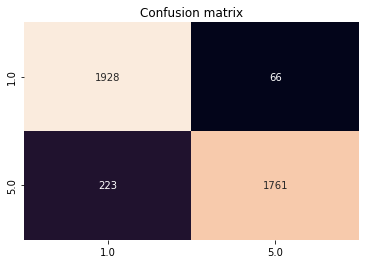

In [ ]:
clf = Pipeline([
    ('transformation', transformer),
    ('clf', RandomForestClassifier(criterion='entropy', n_estimators=500, max_depth=9, random_state=0))
    ])

clf.fit(X_train, y_train)  
pred = clf.predict(X_test)
print(classification_report(pred, y_test))

sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title("Confusion matrix")
plt.show()

Можно увидеть, что качество классификации значительно выросло. При этом, эксперименты показали, что прирост эффективности классификации обеспечивают три фактора:
1. включение в признаковое пространство как униграм, так и биграмм
2. не использование сингулярного разложения 
3. увеличение сложности модели (глубина и количество решаюших деревьев), не приводящей к переобучению

Это привело к увеличению f1-метрики выше 0,9

**Выводы по всей работе:** при расчете данной задачи были выдвинуты некоторые гипотезы о достижении большего качества:

1. при проведении классификации на основе посимвольного анализатора, решено оставить исходный столбец **TEXT** без преобразований, поскольку пунктуционная и прочая несимвольная информация (скобки, многоточия и т.д.) могла иметь какую-то силу в негативном или положительном смысле;

2. также, при формировании лемматизированного текста - столбца **LEMMA**, было уместно оставить предлог "не", как определяющий негативную окраску. Поскольку фразы "не удалось снять деньги" и "удалось снять деньги" после применения стоп-слов станут одинаковы, и не будут иметь предсказательной силы;

3. предполагалось также добавить в анализ столбец заголовка **TITLE**, в предположении, что находяшиеся в нем слова вроде "хорошее обслуживание", "спасибо" и "ужасный офис" помогут в классификации.

Хотя промежуточные эксперименты в ноутбуке не отражены, отмечу, что пункты 2 и 3 действительно помогли улучшить классификацию.